In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path
import glob

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_Isigma_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        sigma = peak.getCorrectedIntensity().sigma()
        qs.append(q)
        Is.append(I/sigma)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()    
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'D19')
diff = expt.getDiffractometer()

data_dir = path.expanduser("~/data/d19/reference_data/thom/y-corrected-data/")
data_files = glob.glob(data_dir + "*.h5")

numors = []

for f in data_files:
    reader = nsx.HDF5DataReader(f,diff)
    # Discard the data with a low number of frames (unlikely to be "production" data)
    if (reader.getNFrames() < 900):
        continue

    # Build the dataset
    data = nsx.DataSet(reader,diff)

    # Add the data to the experiment
    expt.addData(data)

    numors.append(data)

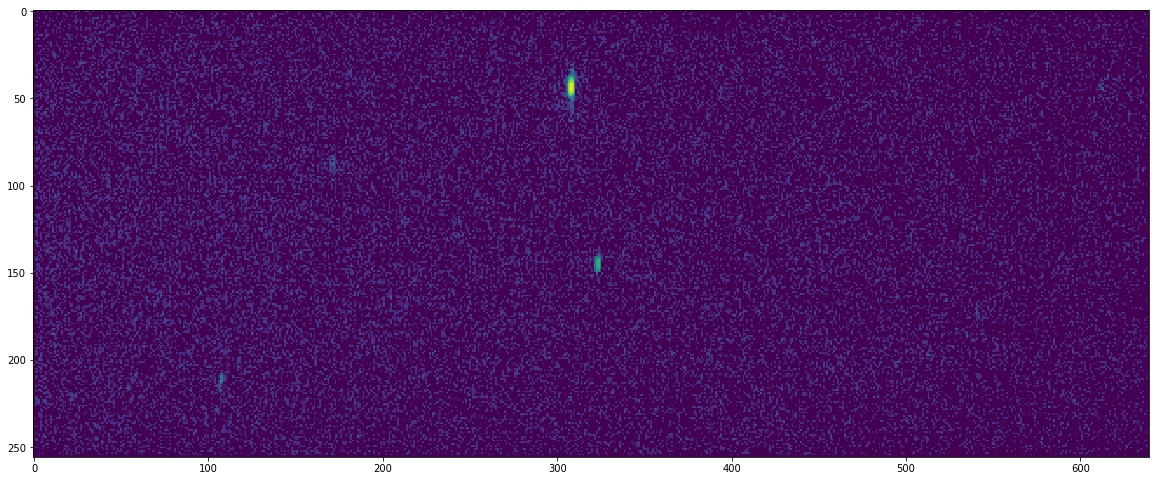

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(1+numors[0].getFrame(100)))
plt.show()

nrows = numors[0].getNRows()
ncols = numors[0].getNCols()

In [5]:
kernel = nsx.AnnularKernel(nrows, ncols)
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(0.4)
finder.setKernel(kernel)

In [7]:
num_numors = len(numors)
peaks = finder.find(numors)
print(peaks.size())
len(numors)

5985


21

In [8]:
for peak in peaks:
       
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)

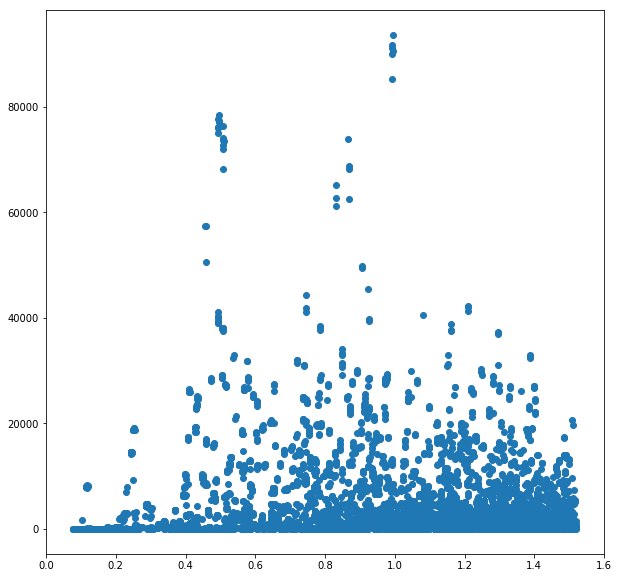

In [9]:
plot_I_vs_q(peaks)

5308


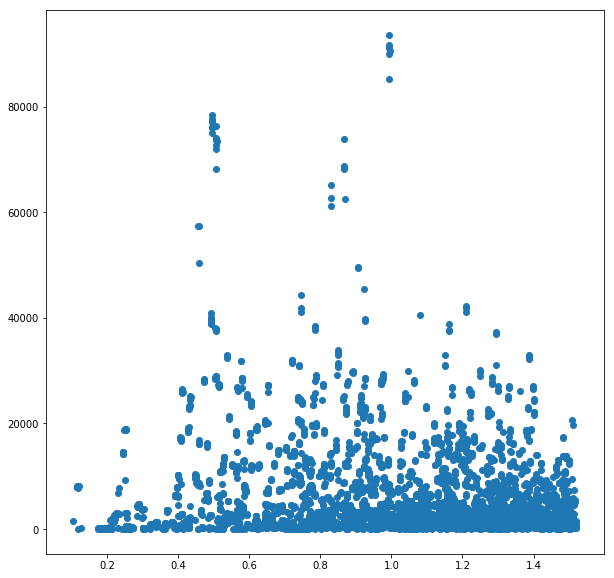

In [10]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 10.0 or d < 0.65:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [11]:
####################################
# AUTO-INDEXING
####################################

indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

params = nsx.IndexerParameters()
indexer.autoIndex(params)

solutions = indexer.getSolutions()

cell_parameters = []

for idx, (uc,score) in enumerate(solutions):

    a     = uc.character().a
    b     = uc.character().b
    c     = uc.character().c
    alpha = np.rad2deg(uc.character().alpha)
    beta  = np.rad2deg(uc.character().beta)
    gamma = np.rad2deg(uc.character().gamma)

    cell_parameters.append((idx,a,b,c,alpha,beta,gamma,score))

    print("idx: {0:3d} --- a = {1:6.2f}  b = {2:6.2f}  c = {3:6.2f}  alpha = {4:6.2f}  beta = {5:6.2f}  gamma = {6:6.2f} --- % indexed = {7:5.2f}".format(*(cell_parameters[-1])))


idx:   0 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.57
idx:   1 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.42  gamma =  90.00 --- % indexed = 99.57
idx:   2 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.42  gamma =  90.00 --- % indexed = 99.57
idx:   3 --- a =   5.58  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.57
idx:   4 --- a =   5.58  b =   5.55  c =  16.19  alpha =  90.00  beta =  83.57  gamma =  90.00 --- % indexed = 99.55
idx:   5 --- a =   5.58  b =  11.09  c =  17.10  alpha =  71.10  beta =  83.92  gamma =  89.95 --- % indexed = 99.53
idx:   6 --- a =   5.58  b =   5.55  c =  16.20  alpha =  90.00  beta =  96.39  gamma =  90.00 --- % indexed = 99.51
idx:   7 --- a =  11.15  b =   5.55  c =  16.18  alpha =  90.00  beta =  96.41  gamma =  90.00 --- % indexed = 99.47
idx:   8 --- a =  11.16  b =   5.55  c =  16.19  alpha =  90.00 

In [12]:
# take best unit cell
uc = solutions[0][0]

for peak in good_peaks:
    peak.addUnitCell(uc, True)

In [13]:
####################################
# SPACE-GROUP
####################################

compatible_space_groups = uc.compatibleSpaceGroups()

hkls = nsx.MillerIndexList()

for peak in good_peaks:
    hkls.push_back(uc.getIntegerMillerIndices(peak.getQ()))

space_groups = []
for idx,symbol in enumerate(compatible_space_groups):
    sg = nsx.SpaceGroup(symbol)
    space_groups.append((idx,symbol,100.0*(1.0-sg.fractionExtinct(hkls))))
    print("idx: {0:3d} --- symbol = {1:10s}  --- % non-extincted peaks = {2:6.2f}".format(*(space_groups[-1])))

idx:   0 --- symbol = P 2         --- % non-extincted peaks = 100.00
idx:   1 --- symbol = P 21        --- % non-extincted peaks =  99.98
idx:   2 --- symbol = P m         --- % non-extincted peaks = 100.00
idx:   3 --- symbol = P c         --- % non-extincted peaks =  99.91
idx:   4 --- symbol = P 2/m       --- % non-extincted peaks = 100.00
idx:   5 --- symbol = P 21/m      --- % non-extincted peaks =  99.98
idx:   6 --- symbol = P 2/c       --- % non-extincted peaks =  99.91
idx:   7 --- symbol = P 21/c      --- % non-extincted peaks =  99.89


In [14]:
peak_set = nsx.PeakSet()

for peak in good_peaks:
    peak_set.insert(peak)

for data in numors:
    data.integratePeaks(peak_set, 5.0, 8.0, nsx.ProgressHandler())
    
compute_statistics(good_peaks, nsx.SpaceGroup("P 21"), True)

{'CChalf': 0.9183111971993131,
 'CCtrue': 0.9784765161003388,
 'Rmeas': 0.17197762884216497,
 'Rmerge': 0.15080596496550241,
 'Rpim': 0.07958319215426733}

In [15]:
#################
# Refinement
#################
refinements = []

for data in numors:
    print("Refining parameters for dataset", data.getFilename())
    nbatches = 1
    states = data.getInstrumentStates()
    
    # testing
    #B = uc.reciprocalBasis()
    #dB = np.random.rand(3,3) * 0.01 * np.linalg.norm(B)
    #uc.setReciprocalBasis(B+dB)
    
    data_peaks = []
    
    for peak in good_peaks:
        if peak.data().getFilename() == data.getFilename():
            data_peaks.append(peak)
            
    #print(len(data_peaks))
    
    refiner = nsx.Refiner(uc, data_peaks, nbatches)
    
    if (len(data_peaks) < 20):
        print("Too few peaks; skipping")
    
    #refiner.refineSamplePosition(states)
    #refiner.refineKi(states)
    #refiner.refineSampleOrientation(states)
    
    #refiner.refineU()
    refiner.refineB()
    
    success = refiner.refine(200)
    
    refinements.append([data, refiner, success])
    print("refinement successful:", success)
    
#refiner.refineU()
    


Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125622.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125562.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125579.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125623.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125571.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125574.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corrected-data/125570.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19/reference_data/thom/y-corre

In [16]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.getDiffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred


In [17]:
predicted = []

for r in refinements:
    data, refiner, success = r
    preds = predict_peaks(good_peaks, data, 0.65, 10.0, uc.reciprocalBasis(), refiner.batches())
    print("Prediced", len(preds), "peaks")
    predicted.extend(preds)
    
print("Total predicted peaks:", len(predicted))

Prediced 274 peaks
Prediced 329 peaks
Prediced 224 peaks
Prediced 265 peaks
Prediced 328 peaks
Prediced 325 peaks
Prediced 260 peaks
Prediced 327 peaks
Prediced 328 peaks
Prediced 337 peaks
Prediced 324 peaks
Prediced 261 peaks
Prediced 325 peaks
Prediced 329 peaks
Prediced 336 peaks
Prediced 269 peaks
Prediced 328 peaks
Prediced 333 peaks
Prediced 264 peaks
Prediced 252 peaks
Prediced 322 peaks
Total predicted peaks: 6340


In [18]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak.setSelected(True)
    peak_set.insert(peak)

for data in numors:
    data.integratePeaks(peak_set, 5.5, 10.0, nsx.ProgressHandler())
    
compute_statistics(predicted, nsx.SpaceGroup("P 21"), True)

{'CChalf': 0.9511242008864061,
 'CCtrue': 0.9873955283129127,
 'Rmeas': 0.10783302217271809,
 'Rmerge': 0.09218780897807777,
 'Rpim': 0.054253949980981715}

In [19]:
nshells = 10
dmin = 0.65
dmax = 8.1

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21"), True))
   
def print_stats():    
    print("   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:8.3f} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f}"
        print(fmt.format(d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
   0.650    0.673    0.060    0.050    0.031    0.994    0.999
   0.673    0.700    0.070    0.057    0.039    0.988    0.997
   0.700    0.732    0.056    0.045    0.032    0.994    0.998
   0.732    0.771    0.102    0.083    0.059    0.965    0.991
   0.771    0.819    0.151    0.120    0.090    0.890    0.970
   0.819    0.882    0.149    0.124    0.083    0.927    0.981
   0.882    0.971    0.080    0.065    0.044    0.959    0.990
   0.971    1.111    0.142    0.121    0.073    0.970    0.992
   1.111    1.398    0.132    0.115    0.064    0.967    0.992
   1.398    8.100    0.076    0.069    0.029    0.994    0.999


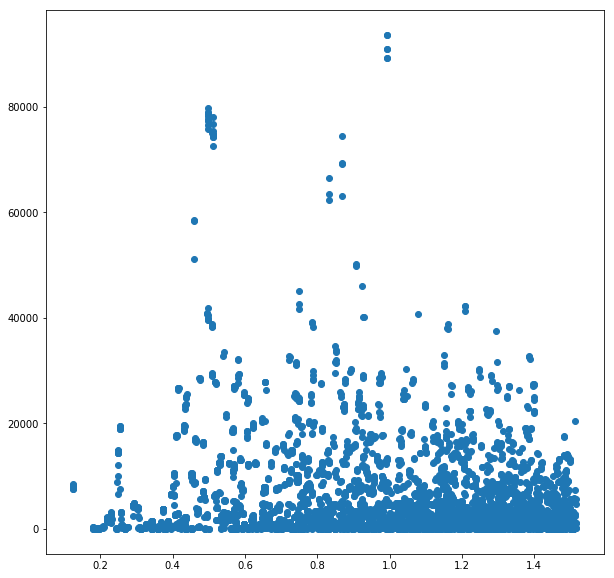

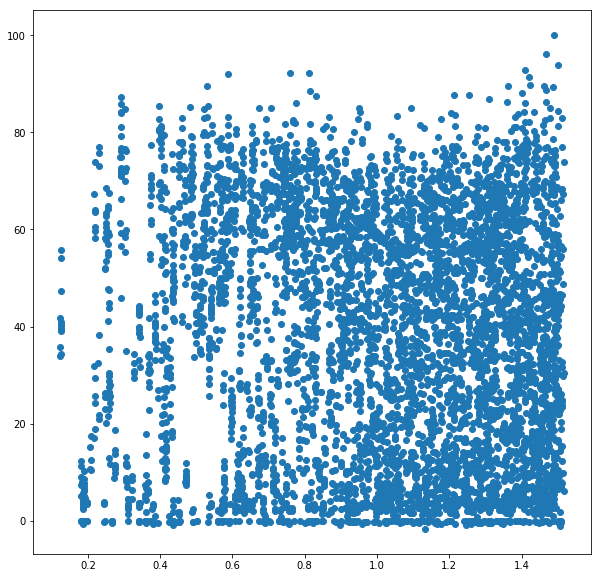

In [20]:
good_predicted = []
lors = []
qs = []

for p in predicted:
    inten = p.getCorrectedIntensity()
    
    state = p.data().getInterpolatedState(p.getShape().center()[2,0])
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    
    # integration failure
    if inten.sigma() < 1.0:
        continue
        
    good_predicted.append(p)

plot_I_vs_q(good_predicted)
plot_Isigma_vs_q(good_predicted)


In [21]:
nshells = 10
dmin = 0.65
dmax = 8.1

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in good_predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:4d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", len(good_predicted))

 n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
 208    0.650    0.673    0.048    0.040    0.026    0.996    0.999
 430    0.673    0.700    0.049    0.040    0.028    0.991    0.998
 438    0.700    0.732    0.041    0.033    0.024    0.993    0.998
 491    0.732    0.771    0.048    0.039    0.027    0.994    0.998
 449    0.771    0.819    0.038    0.031    0.022    0.996    0.999
 552    0.819    0.882    0.050    0.041    0.029    0.992    0.998
 578    0.882    0.971    0.035    0.030    0.019    0.998    0.999
 648    0.971    1.111    0.041    0.034    0.022    0.996    0.999
 734    1.111    1.398    0.041    0.035    0.020    0.993    0.998
1187    1.398    8.100    0.042    0.038    0.017    0.996    0.999
Total peaks 5715


In [23]:
d = []
for p in good_predicted:
    d.append(1.0 / np.linalg.norm(p.getQ().rowVector()))
    
print(min(d))
print(max(d))

0.6594078645199912
8.063604576683693


In [25]:
bad_ex = None
good_ex = None

for peak in peaks:
    if not peak.isSelected():
        continue
        
    inten = peak.getCorrectedIntensity()
    sigma = inten.sigma()
    
    if bad_ex is None and sigma < 1.0:
        bad_ex = peak
        
    if good_ex is None and sigma > 100.0:
        good_ex = peak
        
    if not (bad_ex is None) and not (good_ex is None):
        break

In [29]:
print(bad_ex.getShape().center().transpose())
print()
print(bad_ex.getShape().metric())

[[112.42269327  43.33790524 339.44887781]]

[[ 0.46133191 -0.05678838 -0.14459926]
 [-0.05678838  0.16823813  0.0631108 ]
 [-0.14459926  0.0631108   0.31166011]]


In [30]:
print(good_ex.getShape().center().transpose())
print()
print(good_ex.getShape().metric())

[[528.77388188  93.89597943 657.59661836]]

[[ 0.39135741  0.00163196 -0.23432827]
 [ 0.00163196  0.14010187  0.01901784]
 [-0.23432827  0.01901784  0.26347384]]


In [34]:
print(np.sqrt(1.0 / np.linalg.eig(bad_ex.getShape().metric())[0]))
print(np.sqrt(1.0 / np.linalg.eig(good_ex.getShape().metric())[0]))

[1.32919242 2.08143436 2.63158526]
[1.3238875  3.53164447 2.63339063]


In [35]:
print(bad_ex.data().getFilename())

/home/jonathan/data/d19/reference_data/thom/y-corrected-data/125579.h5


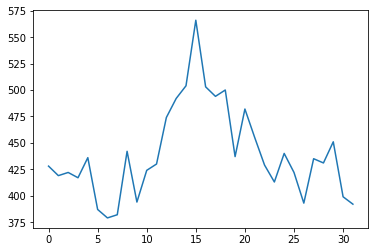

In [37]:
plt.plot(bad_ex.getProjection())
plt.show()

In [39]:
region = bad_ex.getIntegrationRegion()